In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

In [3]:
X = np.array([[-4, -3, -1, 0, 1, 2]]).T
y = np.array([[-3, 1, 2, 4, 1, -2]]).T

In [4]:
model = GPy.models.GPRegression(X, y, kernel)
model.Gaussian_noise.variance = 1e-10
model.Gaussian_noise.variance.fix()
model.optimize()

 /usr/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


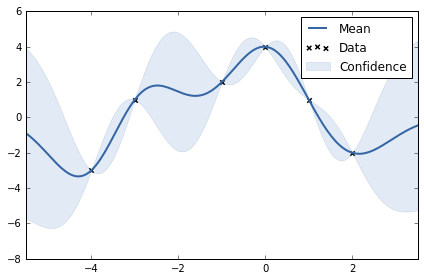

In [5]:
model.plot()

In [6]:
print(model)


Name : GP regression
Objective : 13.43511673759272
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  rbf.variance             |   6.34626286484  |      +ve      |        
  rbf.lengthscale          |  0.838588574695  |      +ve      |        
  Gaussian_noise.variance  |           1e-10  |   +ve fixed   |        


In [7]:
np.savetxt(
    "posterior_data.dat",
    np.hstack((X, y)),
    delimiter='\t',
    comments='',
    header='\t'.join(["X", "y"])
)

In [8]:
Xt = np.arange(-10, 10, 0.05)[:, None]
mu, Sigma = model.predict(Xt, full_cov=True)
twostd = 2 * np.sqrt(np.diag(Sigma)[:, None])

In [9]:
np.savetxt(
    "posterior_gp.dat",
    np.hstack((Xt, mu, twostd)),
    delimiter='\t',
    comments='',
    header='\t'.join(["X", "y", "y_2std"])
)

In [10]:
for i in range(3):
    y = np.random.multivariate_normal(mu[:, 0], Sigma)[:, None]
    stacked = np.hstack((Xt, y))
    np.savetxt(
        "posterior_posterior_sample_{}.dat".format(i),
        stacked,
        delimiter='\t',
        comments='',
        header='\t'.join(["X", "y"])
    )

# Linearization

In [53]:
import numdifftools as nd
import seaborn as sns
from scipy import stats

 /usr/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


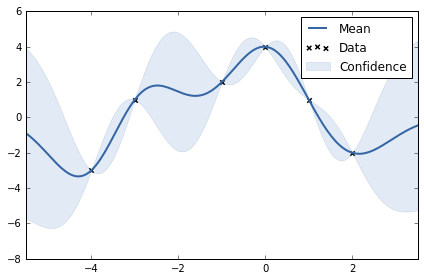

In [11]:
model.plot()

In [113]:
prior_mu = -1.2
prior_var = 0.25

In [114]:
mu = np.array([[prior_mu]])
posterior_mu = model.predict(mu)
posterior_mu

(array([[ 1.57693676]]), array([[ 0.19799414]]))

In [115]:
pred_fun = lambda x: model.predict(np.array([[x]]))[0]
derivative = nd.Derivative(pred_fun)
V = derivative(prior_mu)[0, 0]
V, V * V * prior_var

(1.7511410501706364, 0.76662374439817982)

In [127]:
def sample_posterior(num_samples=500):
    priors = np.random.normal(loc=prior_mu, scale=np.sqrt(prior_var), size=(num_samples, 1))
    return model.predict(priors)[0][:, 0]

0.575840683127


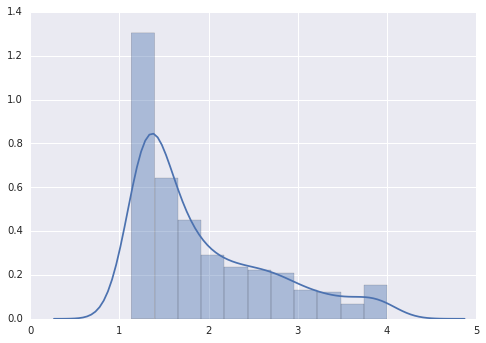

In [128]:
posteriors = sample_posterior()
print(np.var(posteriors))
sns.distplot(posteriors)

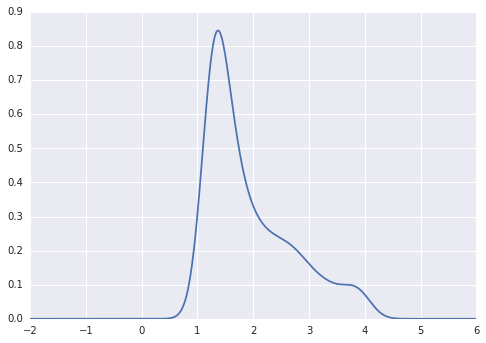

In [129]:
kde = stats.gaussian_kde(posteriors)
grid = np.arange(-2,6,0.01)
grid_kde = kde(grid)
plt.plot(grid, grid_kde)

np.savetxt(
    "solution_ms_linearization_posterior_kde.dat",
    np.vstack((grid, grid_kde)).T,
    delimiter='\t',
    comments='',
    header='\t'.join(["X", "y"])
)